## Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
os.chdir('c:/users/fre_f/pythonprojects/bacteriological/')

In [3]:
df = pd.read_csv('./data/final/05_species_dedornot_ra.csv')

In [4]:
df.head()

,Index,Patient=1,None;Other;Other;Other;Other;Other;Other,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__smithii,k__Bacteria;p__Acidobacteria;c__Acidobacteria;o__NA;f__NA;g__Blastocatella;s__sp3006,k__Bacteria;p__Acidobacteria;c__Holophagae;o__NA;f__NA;g__NA;s__sp3737,k__Bacteria;p__Acidobacteria;c__Holophagae;o__NA;f__NA;g__NA;s__sp4001,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__NA;s__sp4262,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Iamiaceae;g__Iamia;s__sp4310,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Iamiaceae;g__Iamia;s__sp4312,...,k__Bacteria;p__Verrucomicrobia;c__Spartobacteria;o__Chthoniobacterales;f__NA;g__Terrimicrobium;s__sacchariphilum,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia;s__muciniphila,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Haloferula;s__sp69345,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Roseibacillus;s__sp69392,Gender F=1,Age,Lenses (Y_N),Antibiotics (B_A),OSDI score,DEQ5 score
0,P1,1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,1,65,0,0,NaN,NaN
1,P2,1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,1,67,0,0,31.25,17.0
2,P3,1,0.000233,0.007146,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01888,0.0,0.0,1,33,0,0,33.30,16.0
3,P4,1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,1,66,0,0,93.75,21.0
4,P5,1,0.000164,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0,69,0,0,6.25,7.0


In [5]:
df.iloc[:,2:1340]

,None;Other;Other;Other;Other;Other;Other,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__smithii,k__Bacteria;p__Acidobacteria;c__Acidobacteria;o__NA;f__NA;g__Blastocatella;s__sp3006,k__Bacteria;p__Acidobacteria;c__Holophagae;o__NA;f__NA;g__NA;s__sp3737,k__Bacteria;p__Acidobacteria;c__Holophagae;o__NA;f__NA;g__NA;s__sp4001,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__NA;s__sp4262,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Iamiaceae;g__Iamia;s__sp4310,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Iamiaceae;g__Iamia;s__sp4312,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Iamiaceae;g__Iamia;s__sp4316,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__NA;g__NA;s__sp4642,...,k__Bacteria;p__Tenericutes;c__Mollicutes;o__NA;f__NA;g__NA;s__sp67941,k__Bacteria;p__Thermotogae;c__Thermotogae;o__Thermotogales;f__Thermotogaceae;g__NA;s__sp68412,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__NA;f__NA;g__NA;s__sp68841,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__Opitutales;f__Opitutaceae;g__Opitutus;s__sp68878,k__Bacteria;p__Verrucomicrobia;c__Spartobacteria;o__Chthoniobacterales;f__Chthoniobacteraceae;g__Chthoniobacter;s__sp69092,k__Bacteria;p__Verrucomicrobia;c__Spartobacteria;o__Chthoniobacterales;f__Chthoniobacteraceae;g__Chthoniobacter;s__sp69093,k__Bacteria;p__Verrucomicrobia;c__Spartobacteria;o__Chthoniobacterales;f__NA;g__Terrimicrobium;s__sacchariphilum,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia;s__muciniphila,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Haloferula;s__sp69345,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Roseibacillus;s__sp69392
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.000233,0.007146,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01888,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.000164,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.000128,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
87,0.000153,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
88,0.000395,0.000000,0.0,0.0,0.0,0.000443,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
89,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [6]:
df.iloc[:,1]

0     1
1     1
2     1
3     1
4     1
     ..
86    0
87    0
88    0
89    0
90    0
Name: Patient=1, Length: 91, dtype: int64

In [7]:
X = df.iloc[:,2:1340]
y = df.iloc[:,1]

## Cross validate with leave one out and explain according to average of estimators

### XGBoost

In [8]:
clfxgb = XGBClassifier(random_state=42)
scoring = ['accuracy', 'f1', 'precision', 'recall']
xgb_scores = cross_validate(clfxgb, X, y, cv=5, scoring=scoring, return_estimator=True)

In [9]:
print(f'Accuracy XGB: ', np.mean(xgb_scores['test_accuracy']))
print(f'F1 score XGB: ', np.mean(xgb_scores['test_f1']))
print(f'Precision XGB: ', np.mean(xgb_scores['test_precision']))
print(f'Recall XGB: ', np.mean(xgb_scores['test_recall']))

Accuracy XGB:  0.6374269005847953
F1 score XGB:  0.7460464822533788
Precision XGB:  0.7011904761904761
Recall XGB:  0.8025641025641026


In [10]:
feature_importances_complete = []

for idx, estimator in enumerate(xgb_scores['estimator']):
    #print(f'The most important features for estimator {idx}:')
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    #print(feature_importances)
    feature_importances_complete.append(feature_importances)

feature_importances_complete = pd.concat(feature_importances_complete)

In [11]:
feature_importances_complete.shape

(6690, 1)

In [12]:
fic = feature_importances_complete.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [13]:
fic[:15]

,Importance
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Propionibacterium;s__granulosum,0.135158
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__sanguinis,0.062027
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Subdoligranulum;s__sp35582,0.040520
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__sp32056,0.037805
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Azospirillum-Skermanella;s__sp45983-sp46213,0.036566
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Atopostipes;s__suicloacalis,0.034936
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__NA,0.033462
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__dorei,0.031950
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__NA;s__sp5276,0.031319
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__pseudogenitalium-tuberculostearicum,0.026849


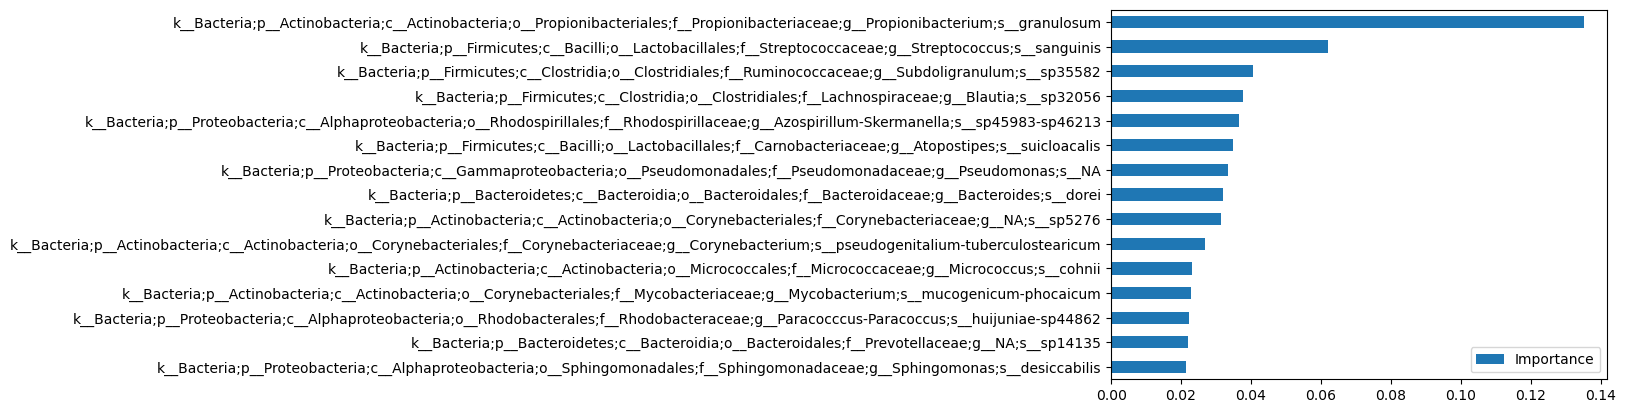

In [14]:
plot_fic = fic[:15]
plot_fic.plot(kind='barh').invert_yaxis()

In [15]:
for estimator in xgb_scores['estimator']:
    explainerxgb = shap.Explainer(estimator, X)
    shap_valuesxgb = explainerxgb.shap_values(X)

[10:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [16]:
np.shape(shap_valuesxgb)

(91, 1338)

In [17]:
shap_valuesxgb_mean = np.mean(shap_valuesxgb, axis=0, keepdims=True)

In [18]:
np.shape(shap_valuesxgb_mean)

(1, 1338)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


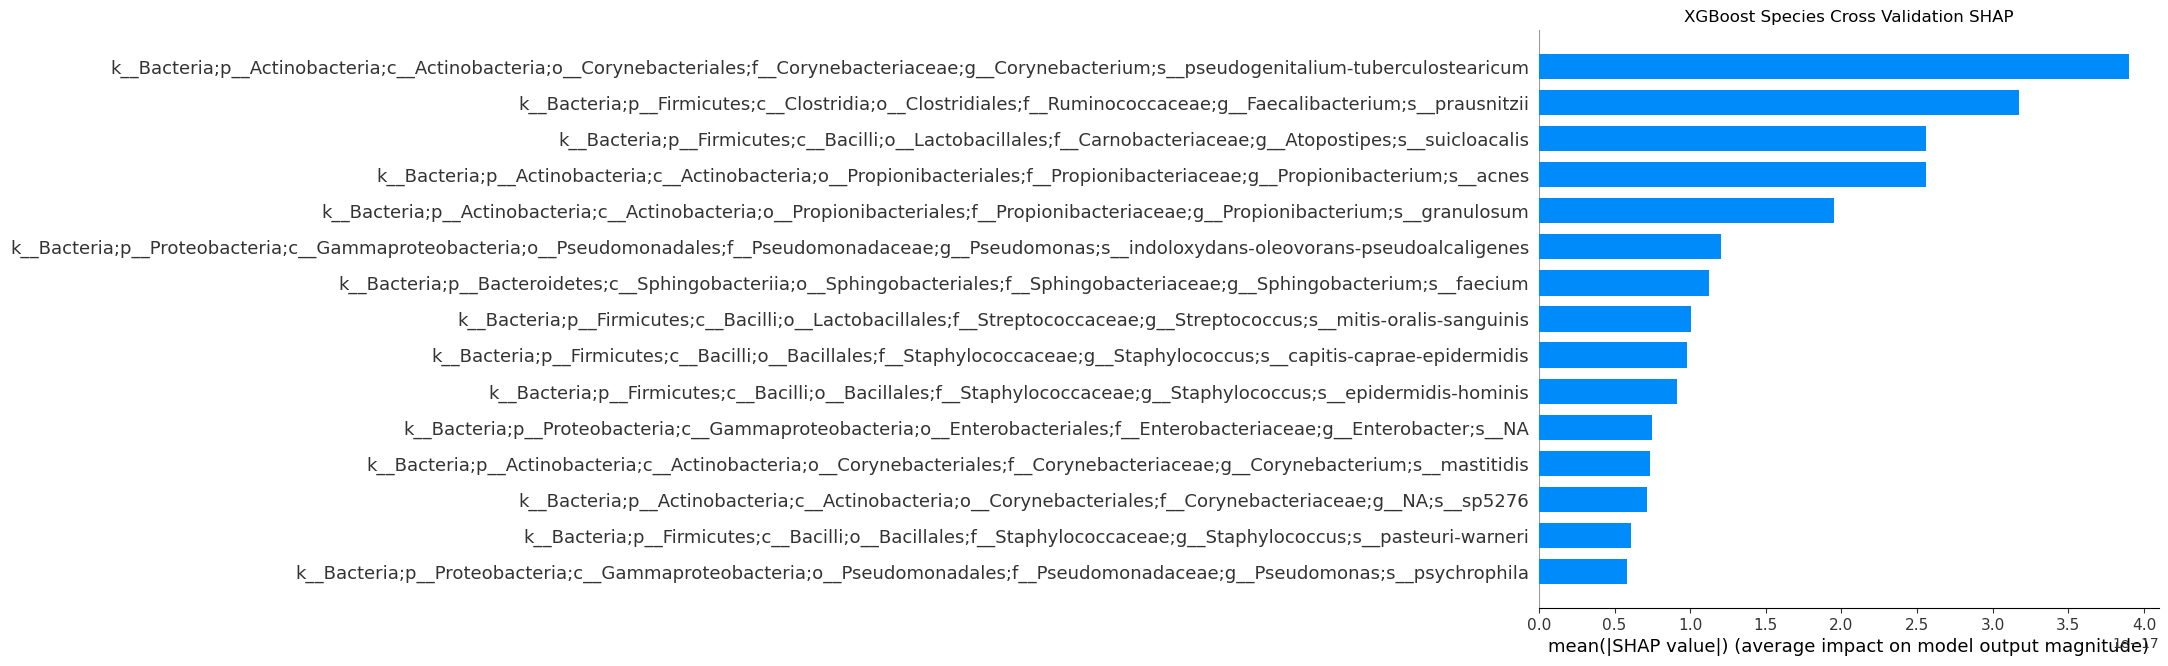

In [19]:
shap.summary_plot(shap_valuesxgb_mean, X, plot_type='bar', max_display=15, show=False)
plt.title('XGBoost Species Cross Validation SHAP')
plt.show()

### LightGBM

In [20]:
clflgbm = LGBMClassifier(random_state=42)
scoring = ['accuracy', 'f1', 'precision', 'recall']
lgbm_scores = cross_validate(clflgbm, X, y, cv=5, scoring=scoring, verbose=False, return_estimator=True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 48, number of negative: 24
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666667 -> initscore=0.693147
[LightGBM] [Info] Start training from score 0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [21]:
print(f'Accuracy LGBM: ', np.mean(lgbm_scores['test_accuracy']))
print(f'F1 score LGBM: ', np.mean(lgbm_scores['test_f1']))
print(f'Precision LGBM: ', np.mean(lgbm_scores['test_precision']))
print(f'Recall LGBM: ', np.mean(lgbm_scores['test_recall']))

Accuracy LGBM:  0.6807017543859648
F1 score LGBM:  0.7703393380812736
Precision LGBM:  0.7419444444444444
Recall LGBM:  0.8166666666666667


In [22]:
feature_importances_complete_lgb = []

for idx, estimator in enumerate(lgbm_scores['estimator']):
    #print(f'The most important features for estimator {idx}:')
    feature_importances_lgb = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    #print(feature_importances_lgb)
    feature_importances_complete_lgb.append(feature_importances_lgb)

feature_importances_complete_lgb = pd.concat(feature_importances_complete_lgb)

In [23]:
fic_lgb = feature_importances_complete_lgb.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [24]:
fic_lgb[:15]

,Importance
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__pseudogenitalium-tuberculostearicum,20.6
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__epidermidis-hominis,14.0
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__monocytogenes-welshimeri,11.6
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__mastitidis,11.6
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Propionibacterium;s__acnes,11.6
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__radioresistens,10.8
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax;s__temperans,9.4
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__NA;s__sp5276,9.0
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__NA,8.6
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__capitis-caprae-epidermidis,8.2


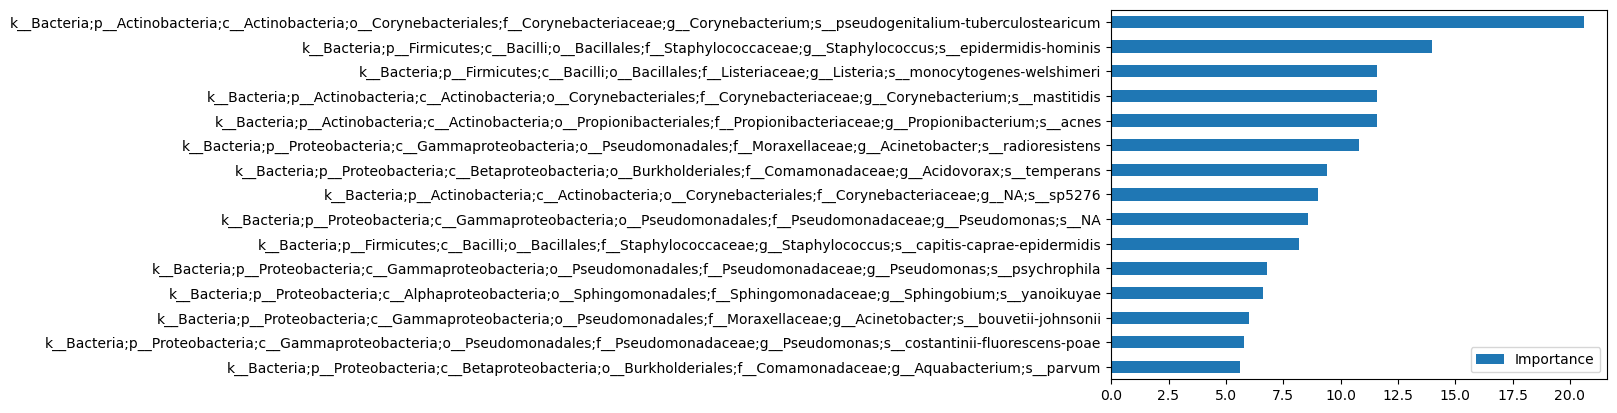

In [25]:
plot_fic_lgb = fic_lgb[:15]
plot_fic_lgb.plot(kind='barh').invert_yaxis()

In [26]:
for estimator in lgbm_scores['estimator']:
    explainerlgb = shap.Explainer(estimator, X)
    shap_valueslgb = explainerlgb.shap_values(X)    
    

In [27]:
np.shape(shap_valueslgb)

(91, 1338)

In [28]:
shap_valueslgb_mean = np.mean(shap_valueslgb, axis=0, keepdims=True)

In [29]:
np.shape(shap_valueslgb_mean)

(1, 1338)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


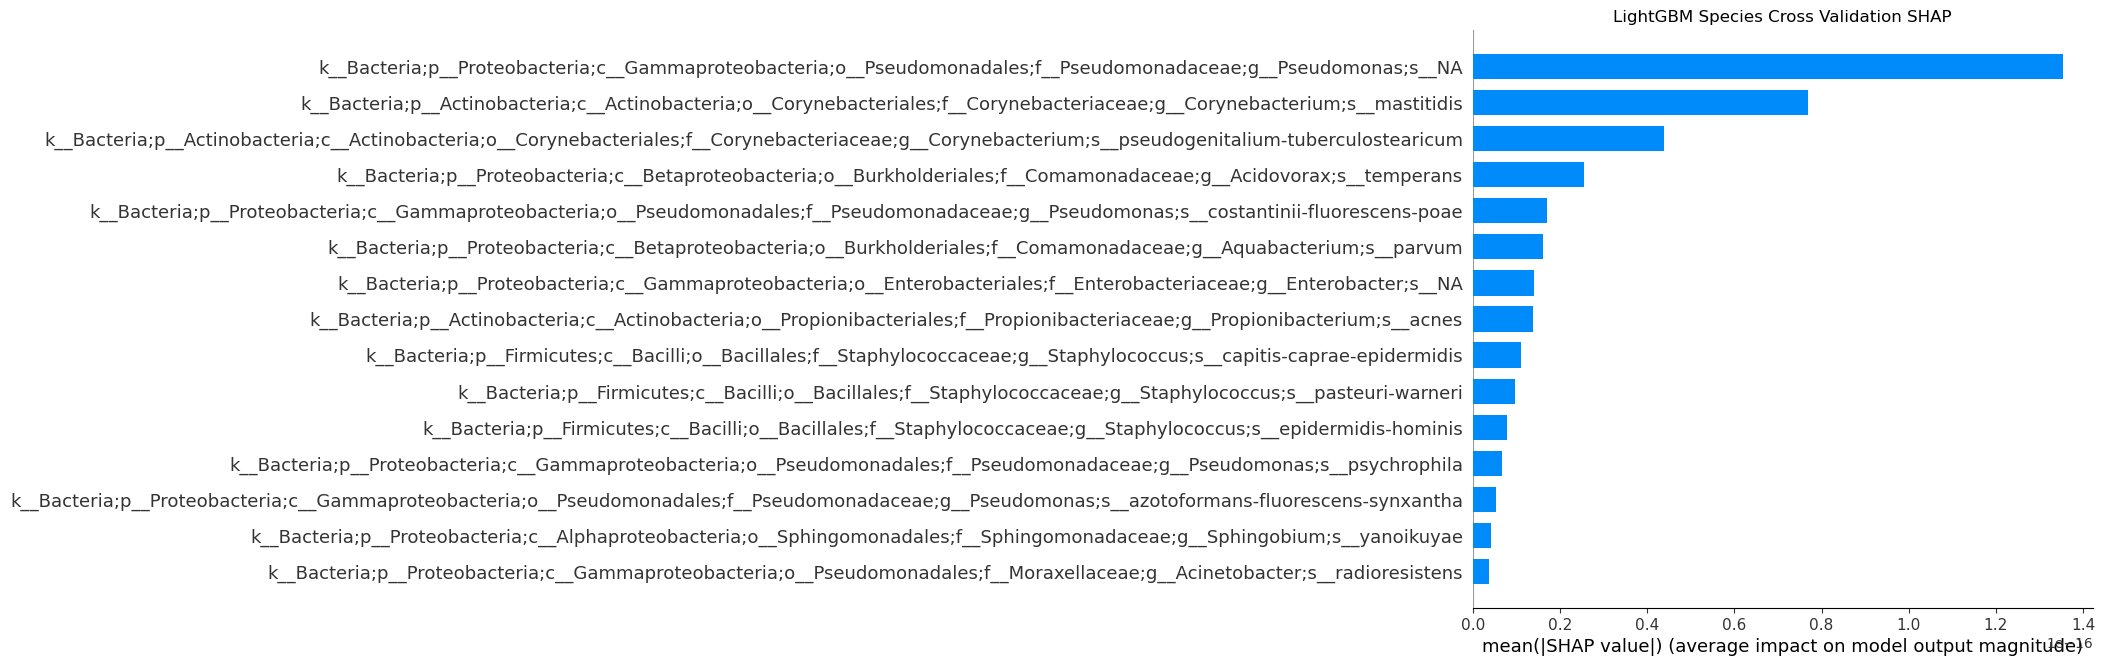

In [30]:
shap.summary_plot(shap_valueslgb_mean, X, plot_type='bar', max_display=15, show=False)
plt.title('LightGBM Species Cross Validation SHAP')
plt.show()

### Multilayer perceptron 

In [31]:
from sklearn.neural_network import MLPClassifier
clfmlp = MLPClassifier(solver="adam", activation="relu", learning_rate="constant", random_state=42, max_iter=30000, verbose=False)
clfmlp.out_activation_="softmax"

scoring = ['accuracy', 'f1', 'precision', 'recall']
mlp_scores = cross_validate(clfmlp, X, y, cv=5, scoring=scoring, return_estimator=True)

In [32]:
print(f'Accuracy MLP: ', np.mean(mlp_scores['test_accuracy']))
print(f'F1 score MLP: ', np.mean(mlp_scores['test_f1']))
print(f'Precision MLP: ', np.mean(mlp_scores['test_precision']))
print(f'Recall MLP: ', np.mean(mlp_scores['test_recall']))

Accuracy MLP:  0.6801169590643276
F1 score MLP:  0.7509360205012379
Precision MLP:  0.758961038961039
Recall MLP:  0.7512820512820513


In [33]:
# Every estimator in mlp_scores need to be fitted and permutation importance run on each estimator.
MLP_feature_importances_complete = []

for idx, estimator in enumerate(mlp_scores['estimator']):
    mlpimportance = estimator.fit(X, y)
    result = permutation_importance(mlpimportance,X, y,n_repeats=20, random_state = 42)
    MLPfeatures = pd.DataFrame(mlpimportance.feature_names_in_,columns=['Features'])
    MLPfeatures['Importance'] = result.importances_mean.tolist()
    #Sort by importance
    MLPfeatures = MLPfeatures.sort_values(by = 'Importance',ascending=False)
    #print(f'The most important features for estimator {idx}:')
    #print(MLPfeatures)
    MLP_feature_importances_complete.append(MLPfeatures)

MLP_feature_importances_complete = pd.concat(MLP_feature_importances_complete)

In [34]:
MLPfeatures.shape

(1338, 2)

In [35]:
MLP_feature_importances_complete.shape

(6690, 2)

In [36]:
fic_mlp = MLP_feature_importances_complete.groupby('Features').mean().sort_values('Importance', ascending=False)

In [37]:
fic_mlp.shape

(1338, 1)

In [38]:
fic_mlp[:15]

,Importance
Features,
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__capitis-caprae-epidermidis,0.052747
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Propionibacterium;s__acnes,0.039011
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__NA;s__sp50014,0.018132
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__pasteuri,0.013736
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__NA;s__sp50017,0.012088
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__kroppenstedtii,0.012088
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__pasteuri-warneri,0.010989
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Family XII;g__Exiguobacterium;s__aurantiacum-mexicanum,0.010989
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__mastitidis,0.010989


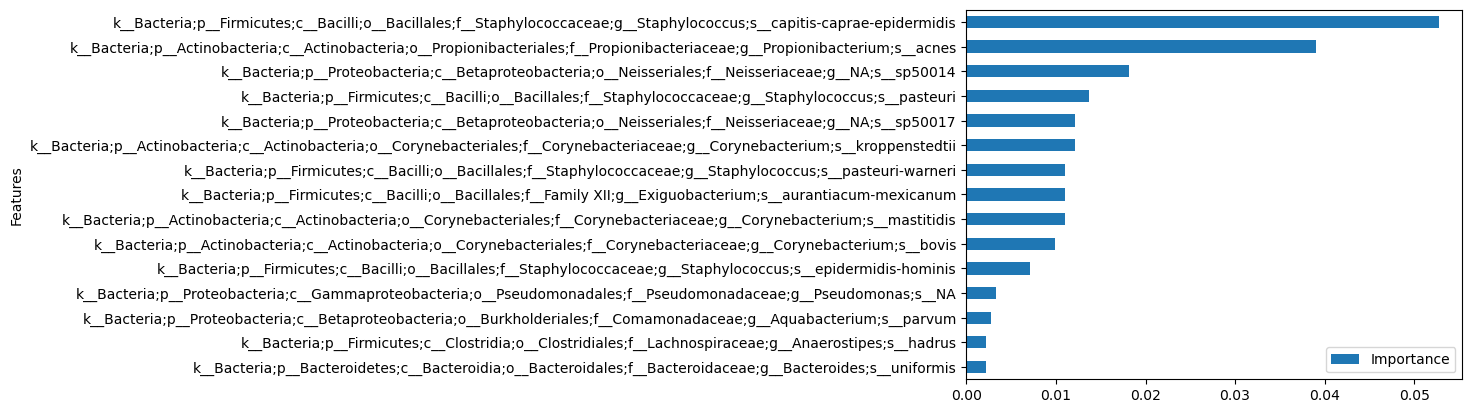

In [39]:
plot_fic_mlp = fic_mlp[:15]
plot_fic_mlp.plot(kind='barh').invert_yaxis()

In [40]:
for estimator in mlp_scores['estimator']:
    explainermlp = shap.Explainer(mlpimportance.predict, X)
    shap_valuesmlp = explainermlp.shap_values(X)

Permutation explainer: 92it [05:47,  3.90s/it]                        
Permutation explainer: 92it [05:46,  3.89s/it]                        
Permutation explainer: 92it [05:48,  3.92s/it]                        
Permutation explainer: 92it [05:47,  3.91s/it]                        
Permutation explainer: 92it [06:05,  4.11s/it]                        


In [41]:
np.shape(shap_valuesmlp)

(91, 1338)

In [42]:
shap_valuesmlp_mean = np.mean(shap_valuesmlp, axis=0, keepdims=True)

In [43]:
np.shape(shap_valuesmlp_mean)

(1, 1338)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


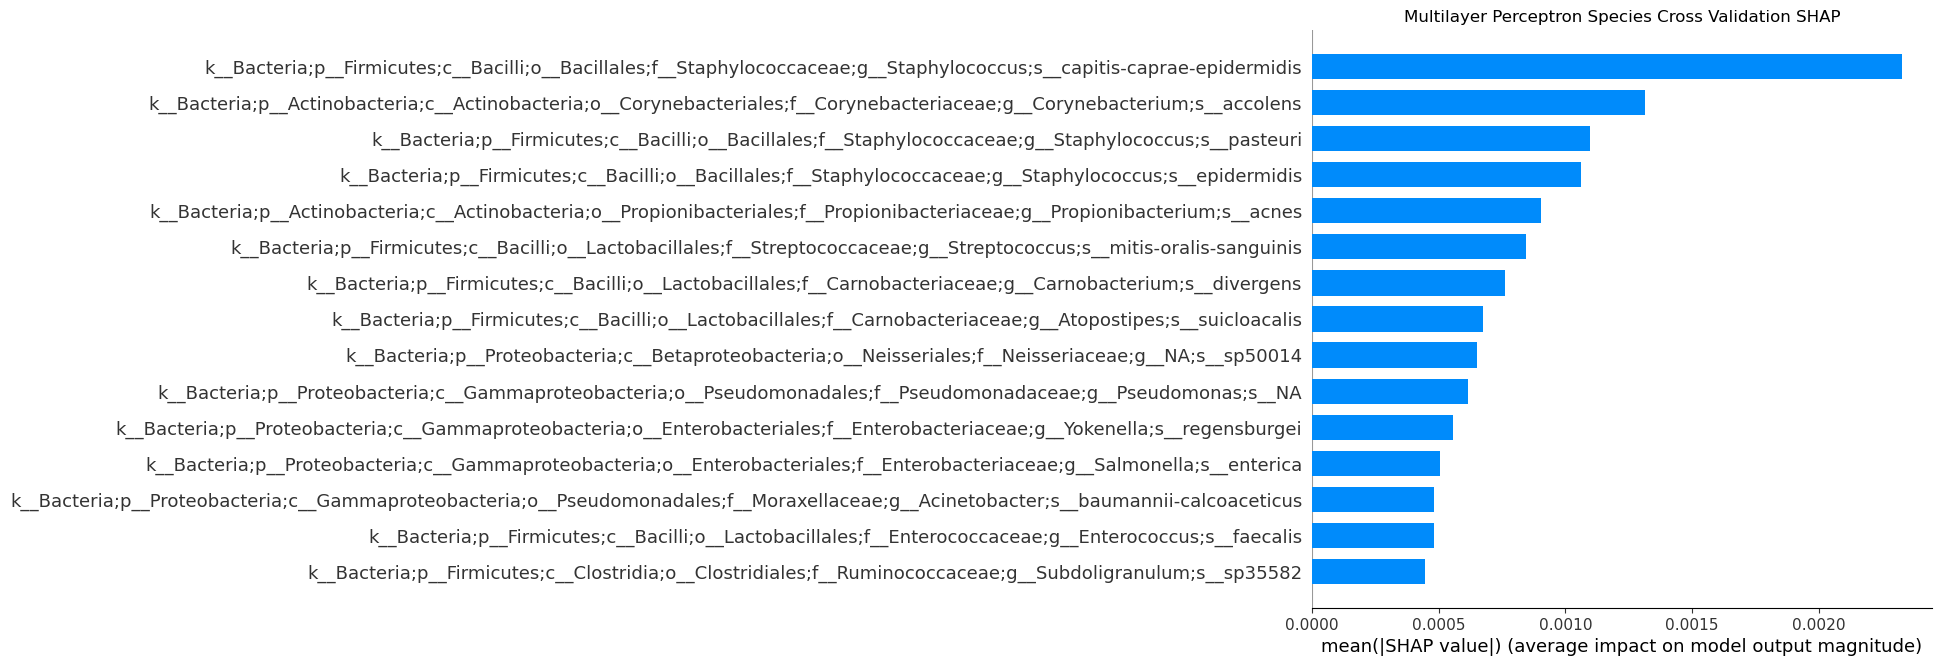

In [44]:
shap.summary_plot(shap_valuesmlp_mean, X, plot_type='bar', max_display=15, show=False)
plt.title('Multilayer Perceptron Species Cross Validation SHAP')
plt.show()